#### Iris 데이터 세트를 Spark DataFrame으로 로드

In [0]:
# Iris를 사용하는 이유 : Binary Classification만 가능하다는 것을 보여주기 위해
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# iris 데이터 세트 로딩
iris = load_iris()
iris_data = iris.data
iris_label = iris.target

# iris 데이터 세트를 numpy에서 pandas DataFrame으로 변환 
iris_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

iris_pdf = pd.DataFrame(iris_data, columns=iris_columns)
iris_pdf['label'] = iris_label

iris_sdf = spark.createDataFrame(iris_pdf)
display(iris_sdf.limit(10))


sepal_length,sepal_width,petal_length,petal_width,label
5.1,3.5,1.4,0.2,0
4.9,3.0,1.4,0.2,0
4.7,3.2,1.3,0.2,0
4.6,3.1,1.5,0.2,0
5.0,3.6,1.4,0.2,0
5.4,3.9,1.7,0.4,0
4.6,3.4,1.4,0.3,0
5.0,3.4,1.5,0.2,0
4.4,2.9,1.4,0.2,0
4.9,3.1,1.5,0.1,0


In [0]:
from pyspark.sql.functions import count, isnan, when, col

# cancer_sdf의 schema 확인
print(iris_sdf.printSchema())

# cancer_sdf에서 Null값이 있는 컬럼 확인
display(iris_sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in iris_sdf.columns]))

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- label: long (nullable = true)

None


sepal_length,sepal_width,petal_length,petal_width,label
0,0,0,0,0


In [0]:
display(iris_sdf.describe())

summary,sepal_length,sepal_width,petal_length,petal_width,label
count,150,150,150,150,150
mean,5.843333333333334,3.0573333333333337,3.7579999999999996,1.1993333333333334,1.0
stddev,0.8280661279778632,0.4358662849366985,1.7652982332594664,0.7622376689603465,0.8192319205190404
min,4.3,2.0,1.0,0.1,0
max,7.9,4.4,6.9,2.5,2


In [0]:
# label 값별 건수 조사
display(iris_sdf.groupBy('label').count())

label,count
0,50
1,50
2,50


In [0]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

# feature 컬럼들을 vectorization 적용. 
vectorAssembler = VectorAssembler(inputCols=iris_columns, outputCol="features")
vectorized_sdf = vectorAssembler.transform(iris_sdf)

# vectorized된 DataFrame을 학습 데이터와 테스트 데이터로 분리 
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2023)

### Decision Tree로 학습 및 예측

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(featuresCol='features', labelCol='label'
                                      , maxDepth=4, minInstancesPerNode=5)
dt_model = dt_classifier.fit(train_sdf)
dt_predictions = dt_model.transform(test_sdf)

In [0]:
print(type(dt_model))

<class 'pyspark.ml.classification.DecisionTreeClassificationModel'>


In [0]:
display(dt_predictions)

sepal_length,sepal_width,petal_length,petal_width,label,features,rawPrediction,probability,prediction
5.0,3.4,1.5,0.2,0,"Map(vectorType -> dense, length -> 4, values -> List(5.0, 3.4, 1.5, 0.2))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
4.8,3.1,1.6,0.2,0,"Map(vectorType -> dense, length -> 4, values -> List(4.8, 3.1, 1.6, 0.2))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
5.0,3.0,1.6,0.2,0,"Map(vectorType -> dense, length -> 4, values -> List(5.0, 3.0, 1.6, 0.2))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
5.1,3.7,1.5,0.4,0,"Map(vectorType -> dense, length -> 4, values -> List(5.1, 3.7, 1.5, 0.4))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
5.1,3.8,1.5,0.3,0,"Map(vectorType -> dense, length -> 4, values -> List(5.1, 3.8, 1.5, 0.3))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
5.5,4.2,1.4,0.2,0,"Map(vectorType -> dense, length -> 4, values -> List(5.5, 4.2, 1.4, 0.2))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
4.5,2.3,1.3,0.3,0,"Map(vectorType -> dense, length -> 4, values -> List(4.5, 2.3, 1.3, 0.3))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
5.0,3.3,1.4,0.2,0,"Map(vectorType -> dense, length -> 4, values -> List(5.0, 3.3, 1.4, 0.2))","Map(vectorType -> dense, length -> 3, values -> List(42.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0.0
6.9,3.1,4.9,1.5,1,"Map(vectorType -> dense, length -> 4, values -> List(6.9, 3.1, 4.9, 1.5))","Map(vectorType -> dense, length -> 3, values -> List(0.0, 40.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0))",1.0
5.6,2.5,3.9,1.1,1,"Map(vectorType -> dense, length -> 4, values -> List(5.6, 2.5, 3.9, 1.1))","Map(vectorType -> dense, length -> 3, values -> List(0.0, 40.0, 0.0))","Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0))",1.0


In [0]:
dt_classifier.extractParamMap()

Out[9]: {Param(parent='DecisionTreeClassifier_050b842c2067', name='seed', doc='random seed.'): 956191873026065186,
 Param(parent='DecisionTreeClassifier_050b842c2067', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4,
 Param(parent='DecisionTreeClassifier_050b842c2067', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='DecisionTreeClassifier_050b842c2067', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 5,
 Param(parent='DecisionTreeClassifier_050b842c2067', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(pa

In [0]:
#estimator 클래스가 가지는 parameter들. hyper parameter와 로직 구성을 위한 다른 parameter들을 함께 가지고 있음. 
dt_param_names = [(param_key.name, value) for param_key, value in dt_classifier.extractParamMap().items()]
dt_param_names

Out[10]: [('seed', 956191873026065186),
 ('maxDepth', 4),
 ('maxBins', 32),
 ('minInstancesPerNode', 5),
 ('minInfoGain', 0.0),
 ('maxMemoryInMB', 256),
 ('cacheNodeIds', False),
 ('checkpointInterval', 10),
 ('impurity', 'gini'),
 ('leafCol', ''),
 ('minWeightFractionPerNode', 0.0),
 ('predictionCol', 'prediction'),
 ('featuresCol', 'features'),
 ('labelCol', 'label'),
 ('rawPredictionCol', 'rawPrediction'),
 ('probabilityCol', 'probability')]

In [0]:
# Decision Tree의 EstimatorModel을 display()할 경우 결정 트리 룰트리를 시각화 할 수 있음.
display(dt_model)

treeNode
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":2.5999999999999996,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":1.75,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":4.95,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":2.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":2.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


In [0]:
print('feature 갯수:', dt_model.numFeatures, 'class 갯수:', dt_model.numClasses, 'label column명:', dt_model.getLabelCol())
print('결정트리 노드 갯수:', dt_model.numNodes, '결정트리 깊이:', dt_model.depth)
print('결정트리 피처 중요도:', dt_model.featureImportances)

feature 갯수: 4 class 갯수: 3 label column명: label
결정트리 노드 갯수: 7 결정트리 깊이: 3
결정트리 피처 중요도: (4,[2,3],[0.5919318497089325,0.40806815029106747])


In [0]:
from pyspark.ml.linalg import DenseVector

print('dt_model.featureImportance 결과 type:', type(dt_model.featureImportances))
dt_ftr_importances = DenseVector(dt_model.featureImportances)
print('Dense Vector 변환 후 type과 값:', type(dt_ftr_importances), dt_ftr_importances)

dt_model.featureImportance 결과 type: <class 'pyspark.ml.linalg.SparseVector'>
Dense Vector 변환 후 type과 값: <class 'pyspark.ml.linalg.DenseVector'> [0.0,0.0,0.5919318497089325,0.40806815029106747]


In [0]:
dt_ftr_importances_list = list(dt_ftr_importances)
for name, value in zip(iris_sdf.columns, dt_ftr_importances_list):
    print('name:', name, 'value:', value)

name: sepal_length value: 0.0
name: sepal_width value: 0.0
name: petal_length value: 0.5919318497089325
name: petal_width value: 0.40806815029106747


In [0]:
iris_columns

Out[15]: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

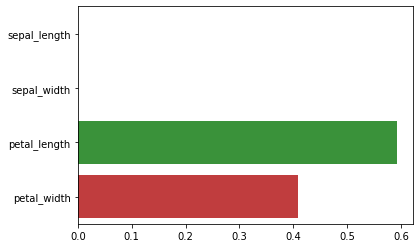

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=dt_ftr_importances_list, y=iris_columns)
plt.show()

### Random Forest로 학습, 예측

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='label'
                                       , maxDepth=4, numTrees=100)
rf_model = rf_classifier.fit(train_sdf)
rf_predictions = rf_model.transform(test_sdf)

In [0]:
rf_params = [(param.name, value) for param, value in rf_classifier.extractParamMap().items()]
rf_params

Out[18]: [('seed', -5387697053847413545),
 ('maxDepth', 4),
 ('maxBins', 32),
 ('minInstancesPerNode', 1),
 ('minInfoGain', 0.0),
 ('maxMemoryInMB', 256),
 ('cacheNodeIds', False),
 ('checkpointInterval', 10),
 ('impurity', 'gini'),
 ('numTrees', 100),
 ('featureSubsetStrategy', 'auto'),
 ('subsamplingRate', 1.0),
 ('leafCol', ''),
 ('minWeightFractionPerNode', 0.0),
 ('bootstrap', True),
 ('predictionCol', 'prediction'),
 ('featuresCol', 'features'),
 ('labelCol', 'label'),
 ('rawPredictionCol', 'rawPrediction'),
 ('probabilityCol', 'probability')]

In [0]:
# DecisionTree Model이 아닌 경우 트리 룰을 시각화 하지는 않음. 
display(rf_model)

---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
<command-4485568648551172> in <cell line: 2>()
      1 # DecisionTree Model이 아닌 경우 트리 룰을 시각화 하지는 않음.
----> 2 display(rf_model)

/databricks/python_shell/dbruntime/display.py in display(self, input, *args, **kwargs)
     96                 self.add_custom_display_data("mlModel", (mlModel, mlPlotType, displayRDD))
     97             else:
---> 98                 raise Exception("ML model display does not yet support model type {}.".format(
     99                     type(input)))
    100         elif input is not None and "help" in dir(input):  # Is this object documented DBC-style?

Exception: ML model display does not yet support model type <class 'pyspark.ml.classification.RandomForestClassificationModel'>.

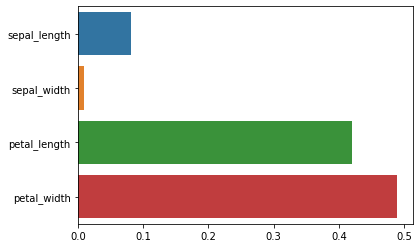

In [0]:
from pyspark.ml.linalg import DenseVector
import matplotlib.pyplot as plt
import seaborn as sns

rf_ftr_importances_list = list(DenseVector(rf_model.featureImportances))

sns.barplot(x=rf_ftr_importances_list, y=iris_columns)
plt.show()

### Gradient Boosting으로 학습, 예측
* GBTClassifier는 Spark 3.2 기준으로 binary classification만 지원하므로 아래는 오류를 발생함

In [0]:
from pyspark.ml.classification import GBTClassifier

gbt_classifier = GBTClassifier(featuresCol='features', labelCol='label'
                                       , maxDepth=4, maxIter=30)
#GBTClassifier는 Spark 3.2 기준으로 binary classification만 지원하므로 아래는 오류를 발생함
gbt_model = gbt_classifier.fit(train_sdf)
gbt_predictions = gbt_model.transform(test_sdf)

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-4485568648551175> in <cell line: 6>()
      4                                        , maxDepth=4, maxIter=30)
      5 #GBTClassifier는 Spark 3.2 기준으로 binary classification만 지원하므로 아래는 오류를 발생함
----> 6 gbt_model = gbt_classifier.fit(train_sdf)
      7 gbt_predictions = gbt_model.transform(test_sdf)

/databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method(self, *args, **kwargs)
     28             call_succeeded = False
     29             try:
---> 30                 result = original_method(self, *args, **kwargs)
     31                 call_succeeded = True
     32                 return result

/databricks/spark/python/pyspark/ml/base.py in fit(self, dataset, params)
    203                 return self.copy(params)._fit(dataset)
    204             else:
--> 205                 return self._f

In [0]:
[param.name for param in gbt_classifier.params]

Out[22]: ['cacheNodeIds',
 'checkpointInterval',
 'featureSubsetStrategy',
 'featuresCol',
 'impurity',
 'labelCol',
 'leafCol',
 'lossType',
 'maxBins',
 'maxDepth',
 'maxIter',
 'maxMemoryInMB',
 'minInfoGain',
 'minInstancesPerNode',
 'minWeightFractionPerNode',
 'predictionCol',
 'probabilityCol',
 'rawPredictionCol',
 'seed',
 'stepSize',
 'subsamplingRate',
 'thresholds',
 'validationIndicatorCol',
 'validationTol',
 'weightCol']

### 위스콘신 암 데이터 세트로 RandomForest, GBT 모델 학습, 예측

In [0]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

# 위스콘신 cancer 데이터 세트를 사이킷런에서 로딩하고 pandas DataFrame으로 변환. 
cancer = load_breast_cancer()
cancer_features = cancer.data
cancer_label = cancer.target
cancer_columns = cancer.feature_names

cancer_pdf = pd.DataFrame(cancer_features, columns=cancer_columns)
cancer_pdf['label'] = cancer_label

# pandas DataFrame을 spark DataFrame으로 변환.
cancer_sdf = spark.createDataFrame(cancer_pdf)
display(cancer_sdf.limit(10))

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0
20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0
19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0
20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0
12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.00751,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244,0
18.25,19.98,119.6,1040.0,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0.4467,0.7732,3.18,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,0
13.0,21.82,87.5,519.8,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0.3063,1.002,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.2,739.3,0.1703,0.5401,0.539,0.206,0.4378,0.1072,0
12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273,0.08543,0.203,0.08243,0.2976,1.599,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.01008,15.09,40.68,97.65,711.4,0.1853,1.058,1.105,0.221,0.4366,0.2075,0


In [0]:
from pyspark.sql.functions import count, isnan, when, col

# cancer_sdf의 schema 확인
print(cancer_sdf.printSchema())

# cancer_sdf에서 Null값이 있는 컬럼 확인
display(cancer_sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cancer_sdf.columns]))

root
 |-- mean radius: double (nullable = true)
 |-- mean texture: double (nullable = true)
 |-- mean perimeter: double (nullable = true)
 |-- mean area: double (nullable = true)
 |-- mean smoothness: double (nullable = true)
 |-- mean compactness: double (nullable = true)
 |-- mean concavity: double (nullable = true)
 |-- mean concave points: double (nullable = true)
 |-- mean symmetry: double (nullable = true)
 |-- mean fractal dimension: double (nullable = true)
 |-- radius error: double (nullable = true)
 |-- texture error: double (nullable = true)
 |-- perimeter error: double (nullable = true)
 |-- area error: double (nullable = true)
 |-- smoothness error: double (nullable = true)
 |-- compactness error: double (nullable = true)
 |-- concavity error: double (nullable = true)
 |-- concave points error: double (nullable = true)
 |-- symmetry error: double (nullable = true)
 |-- fractal dimension error: double (nullable = true)
 |-- worst radius: double (nullable = true)
 |-- worst 

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
display(cancer_sdf.describe())

summary,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
count,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569,569
mean,14.127291739894552,19.289648506151142,91.96903339191563,654.8891036906855,0.09636028119507907,0.10434098418277678,0.0887993158172232,0.04891914586994729,0.18116186291739897,0.06279760984182776,0.4051720562390158,1.2168534270650264,2.8660592267135323,40.337079086116,0.007040978910369067,0.025478138840070295,0.03189371634446397,0.011796137082601054,0.02054229876977153,0.0037949038664323374,16.269189806678384,25.677223198594024,107.26121265377856,880.5831282952548,0.1323685940246046,0.2542650439367311,0.27218848330404216,0.11460622319859401,0.2900755711775044,0.0839458172231986,0.6274165202108963
stddev,3.5240488262120775,4.30103576816695,24.2989810387549,351.914129181653,0.014064128137673623,0.052812757932512194,0.07971980870789348,0.03880284485915361,0.02741428133603572,0.00706036279508446,0.2773127329861039,0.5516483926172023,2.0218545540421076,45.4910055161318,0.003002517943839066,0.017908179325677388,0.030186060322988408,0.006170285174046869,0.008266371528798399,0.002646070967089195,4.8332415804693225,6.146257623038319,33.602542269036356,569.3569926699489,0.02283242940483546,0.15733648891374197,0.2086242806081323,0.06573234119594207,0.06186746753751869,0.018061267348893986,0.48391795640316865
min,6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,0.0,0.106,0.04996,0.1115,0.3602,0.757,6.802,0.001713,0.002252,0.0,0.0,0.007882,8.948E-4,7.93,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504,0
max,28.11,39.28,188.5,2501.0,0.1634,0.3454,0.4268,0.2012,0.304,0.09744,2.873,4.885,21.98,542.2,0.03113,0.1354,0.396,0.05279,0.07895,0.02984,36.04,49.54,251.2,4254.0,0.2226,1.058,1.252,0.291,0.6638,0.2075,1


In [0]:
# label 값별 건수 조사
display(cancer_sdf.groupBy('label').count())

label,count
0,212
1,357


### 위스콘신 데이터를 학습과 테스트용으로 분리하고 RandomForest, GBT 분류 적용.

In [0]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

# feature 컬럼들을 vectorization 적용. 
vectorAssembler = VectorAssembler(inputCols=cancer_columns, outputCol="features")
vectorized_sdf = vectorAssembler.transform(cancer_sdf)

# vectorized된 DataFrame을 학습 데이터와 테스트 데이터로 분리 
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2023)

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth=4, numTrees=100)
rf_model = rf_classifier.fit(train_sdf)
rf_predictions = rf_model.transform(test_sdf)

In [0]:
display(rf_predictions.limit(10))

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label,features,rawPrediction,probability,prediction
11.31,19.04,71.8,394.1,0.08139,0.04701,0.03709,0.0223,0.1516,0.05667,0.2727,0.9429,1.831,18.15,0.009282,0.009216,0.02063,0.008965,0.02183,0.002146,12.33,23.84,78.0,466.7,0.129,0.09148,0.1444,0.06961,0.24,0.06641,1,"Map(vectorType -> dense, length -> 30, values -> List(11.31, 19.04, 71.8, 394.1, 0.08139, 0.04701, 0.03709, 0.0223, 0.1516, 0.05667, 0.2727, 0.9429, 1.831, 18.15, 0.009282, 0.009216, 0.02063, 0.008965, 0.02183, 0.002146, 12.33, 23.84, 78.0, 466.7, 0.129, 0.09148, 0.1444, 0.06961, 0.24, 0.06641))","Map(vectorType -> dense, length -> 2, values -> List(1.5820128205289106, 98.41798717947114))","Map(vectorType -> dense, length -> 2, values -> List(0.015820128205289097, 0.9841798717947109))",1.0
12.78,16.49,81.37,502.5,0.09831,0.05234,0.03653,0.02864,0.159,0.05653,0.2368,0.8732,1.471,18.33,0.007962,0.005612,0.01585,0.008662,0.02254,0.001906,13.46,19.76,85.67,554.9,0.1296,0.07061,0.1039,0.05882,0.2383,0.0641,1,"Map(vectorType -> dense, length -> 30, values -> List(12.78, 16.49, 81.37, 502.5, 0.09831, 0.05234, 0.03653, 0.02864, 0.159, 0.05653, 0.2368, 0.8732, 1.471, 18.33, 0.007962, 0.005612, 0.01585, 0.008662, 0.02254, 0.001906, 13.46, 19.76, 85.67, 554.9, 0.1296, 0.07061, 0.1039, 0.05882, 0.2383, 0.0641))","Map(vectorType -> dense, length -> 2, values -> List(1.6663871107855532, 98.33361288921449))","Map(vectorType -> dense, length -> 2, values -> List(0.016663871107855527, 0.9833361288921445))",1.0
13.64,16.34,87.21,571.8,0.07685,0.06059,0.01857,0.01723,0.1353,0.05953,0.1872,0.9234,1.449,14.55,0.004477,0.01177,0.01079,0.007956,0.01325,0.002551,14.67,23.19,96.08,656.7,0.1089,0.1582,0.105,0.08586,0.2346,0.08025,1,"Map(vectorType -> dense, length -> 30, values -> List(13.64, 16.34, 87.21, 571.8, 0.07685, 0.06059, 0.01857, 0.01723, 0.1353, 0.05953, 0.1872, 0.9234, 1.449, 14.55, 0.004477, 0.01177, 0.01079, 0.007956, 0.01325, 0.002551, 14.67, 23.19, 96.08, 656.7, 0.1089, 0.1582, 0.105, 0.08586, 0.2346, 0.08025))","Map(vectorType -> dense, length -> 2, values -> List(2.2062950840397426, 97.7937049159603))","Map(vectorType -> dense, length -> 2, values -> List(0.022062950840397416, 0.9779370491596027))",1.0
16.74,21.59,110.1,869.5,0.0961,0.1336,0.1348,0.06018,0.1896,0.05656,0.4615,0.9197,3.008,45.19,0.005776,0.02499,0.03695,0.01195,0.02789,0.002665,20.01,29.02,133.5,1229.0,0.1563,0.3835,0.5409,0.1813,0.4863,0.08633,0,"Map(vectorType -> dense, length -> 30, values -> List(16.74, 21.59, 110.1, 869.5, 0.0961, 0.1336, 0.1348, 0.06018, 0.1896, 0.05656, 0.4615, 0.9197, 3.008, 45.19, 0.005776, 0.02499, 0.03695, 0.01195, 0.02789, 0.002665, 20.01, 29.02, 133.5, 1229.0, 0.1563, 0.3835, 0.5409, 0.1813, 0.4863, 0.08633))","Map(vectorType -> dense, length -> 2, values -> List(99.38001199581667, 0.6199880041833289))","Map(vectorType -> dense, length -> 2, values -> List(0.9938001199581667, 0.006199880041833289))",0.0
17.14,16.4,116.0,912.7,0.1186,0.2276,0.2229,0.1401,0.304,0.07413,1.046,0.976,7.276,111.4,0.008029,0.03799,0.03732,0.02397,0.02308,0.007444,22.25,21.4,152.4,1461.0,0.1545,0.3949,0.3853,0.255,0.4066,0.1059,0,"Map(vectorType -> dense, length -> 30, values -> List(17.14, 16.4, 116.0, 912.7, 0.1186, 0.2276, 0.2229, 0.1401, 0.304, 0.07413, 1.046, 0.976, 7.276, 111.4, 0.008029, 0.03799, 0.03732, 0.02397, 0.02308, 0.007444, 22.25, 21.4, 152.4, 1461.0, 0.1545, 0.3949, 0.3853, 0.255, 0.4066, 0.1059))","Map(vectorType -> dense, length -> 2, values -> List(99.46619653524924, 0.5338034647507581))","Map(vectorType ->

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
print('Random Forest 정확도:', evaluator_accuracy.evaluate(rf_predictions))

Random Forest 정확도: 0.9719626168224299


In [0]:
from pyspark.ml.classification import GBTClassifier

gbt_classifier = GBTClassifier(featuresCol='features', labelCol='label'
                                       , maxDepth=4, maxIter=30)
gbt_model = gbt_classifier.fit(train_sdf)
gbt_predictions = gbt_model.transform(test_sdf)

print('GBT 정확도:', evaluator_accuracy.evaluate(gbt_predictions))

GBT 정확도: 0.9439252336448598


### Evaluation
* BinaryClassificationEvaluator, MulticlassClassificationEvaluator 두개의 클래스를 이용하여 성능 평가
* 이진 분류, 멀티 클래스 분류 구분과 클래스 이름과 정확히 매핑되지 않음. 적용시 착각(?)을 일으킬 수 있음. 
* BinaryClassificationEvaluator는 roc-auc 지표만 제공. 
* 정확도(accuracy)를 얻기 위해서는 이진분류 여부와 관계없이 MulticlassClassificationEvaluator 클래스를 사용해야 함. 
* precision, recall, f1-score를 얻기 위해서는 이진분류 여부와 관계없이 MulticlassClassificationEvaluator 클래스를 사용해야 함. 
* MulticlassClassificationEvaluator로 얻어지는 precision, recall은 weighted precision, weighted recall 값임.
* 편리함을 위해서라면 예측 결과 Spark DataFrame을 pandas DataFrame으로 변경하고 사이킷런 평가 API를 사용하는 것이 더 나은 선택일 수 있음.

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_precision = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
evaluator_f1_score = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

In [0]:
print('Random Forest 정밀도(precision):', evaluator_precision.evaluate(rf_predictions))
print('Random Forest 재현율(recall):', evaluator_recall.evaluate(rf_predictions))
print('Random Forest f1 score:', evaluator_f1_score.evaluate(rf_predictions))

Random Forest 정밀도(precision): 0.9723190544422822
Random Forest 재현율(recall): 0.9719626168224298
Random Forest f1 score: 0.9720486788139582


In [0]:
rf_predictions_pdf = rf_predictions.select('label', 'prediction').toPandas()
display(rf_predictions_pdf.head(10))

label,prediction
1,1.0
1,1.0
1,1.0
0,0.0
0,0.0
0,0.0
0,0.0
0,0.0
0,0.0
1,1.0


Random Forest 정밀도(precision): 0.9723190544422822
Random Forest 재현율(recall): 0.9719626168224298
Random Forest f1 score: 0.9720486788139582

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

sk_precision = precision_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_recall = recall_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_precision_weighted = precision_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')
sk_recall_weighted = recall_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')
sk_f1_score = f1_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_f1_score_weighted = f1_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')

print('precision by sklearn:', sk_precision)
print('recall by sklearn:', sk_recall)
print('f1 score by sklearn:', sk_f1_score)
print('weighted precision by sklearn:', sk_precision_weighted)
print('weighted recall by sklearn:', sk_recall_weighted)
print('weighted f1 score by sklearn:', sk_f1_score_weighted)



precision by sklearn: 0.9855072463768116
recall by sklearn: 0.9714285714285714
f1 score by sklearn: 0.9784172661870504
weighted precision by sklearn: 0.9723190544422821
weighted recall by sklearn: 0.9719626168224299
weighted f1 score by sklearn: 0.9720486788139582


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator_roc = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC') #rawPredictionCol=rawPrediction 입력값이 default
print('Random Forest roc auc:', evaluator_roc.evaluate(rf_predictions))

Random Forest roc auc: 0.9957528957528958


In [0]:
rf_predictions.printSchema()

root
 |-- mean radius: double (nullable = true)
 |-- mean texture: double (nullable = true)
 |-- mean perimeter: double (nullable = true)
 |-- mean area: double (nullable = true)
 |-- mean smoothness: double (nullable = true)
 |-- mean compactness: double (nullable = true)
 |-- mean concavity: double (nullable = true)
 |-- mean concave points: double (nullable = true)
 |-- mean symmetry: double (nullable = true)
 |-- mean fractal dimension: double (nullable = true)
 |-- radius error: double (nullable = true)
 |-- texture error: double (nullable = true)
 |-- perimeter error: double (nullable = true)
 |-- area error: double (nullable = true)
 |-- smoothness error: double (nullable = true)
 |-- compactness error: double (nullable = true)
 |-- concavity error: double (nullable = true)
 |-- concave points error: double (nullable = true)
 |-- symmetry error: double (nullable = true)
 |-- fractal dimension error: double (nullable = true)
 |-- worst radius: double (nullable = true)
 |-- worst 

In [0]:
from pyspark.ml.functions import vector_to_array

rf_predictions_pdf = rf_predictions.select('label'
                                           , vector_to_array('probability')[0].alias('probability_0')
                                           , vector_to_array('probability')[1].alias('probability_1')).toPandas()
display(rf_predictions_pdf.head(10))

label,probability_0,probability_1
1,0.015820128205289097,0.9841798717947109
1,0.016663871107855527,0.9833361288921445
1,0.022062950840397416,0.9779370491596027
0,0.9938001199581667,0.006199880041833289
0,0.9946619653524924,0.005338034647507582
0,0.9255392035948052,0.0744607964051947
0,0.9380738291738652,0.06192617082613475
0,0.9944251199581667,0.0055748800418332885
0,0.9944251199581667,0.0055748800418332885
1,0.016537702973133037,0.983462297026867


In [0]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])
print('roc_auc by sklearn:', roc_auc)

roc_auc by sklearn: 0.9957528957528957


In [0]:
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(predictions_sdf, label_column):
    predictions_pdf = predictions_sdf.select(label_column, 'prediction'
                                           , vector_to_array('probability')[0].alias('probability_0')
                                           , vector_to_array('probability')[1].alias('probability_1')).toPandas()
    label = predictions_pdf[label_column].values
    prediction = predictions_pdf['prediction'].values
    probability_1 = predictions_pdf['probability_1'].values
    
    confusion = confusion_matrix(label, prediction)
    accuracy = accuracy_score(label, prediction)
    precision = precision_score(label, prediction)
    recall = recall_score(label, prediction)
    f1 = f1_score(label, prediction)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(label, probability_1)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(rf_predictions, 'label')

오차 행렬
[[36  1]
 [ 2 68]]
정확도: 0.9720, 정밀도: 0.9855, 재현율: 0.9714, F1: 0.9784, AUC:0.9958


In [0]:
from sklearn.metrics import roc_curve

fprs , tprs , thresholds = roc_curve(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])
print('thresholds shape:', thresholds.shape)
# 반환된 임곗값 배열 로우가 21건이므로 샘플로 10건만 추출하되, 임곗값을 2 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 2)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

thresholds shape: (21,)
샘플 추출을 위한 임곗값 배열의 index 10개: [ 0  2  4  6  8 10 12 14 16 18 20]
샘플용 10개의 임곗값:  [1.99 0.99 0.99 0.99 0.65 0.42 0.29 0.12 0.01 0.01 0.01]
샘플 임곗값별 FPR:  [0.    0.    0.025 0.025 0.025 0.05  0.1   0.2   0.75  0.875 1.   ]
샘플 임곗값별 TPR:  [0.    0.054 0.081 0.432 0.905 0.973 0.986 1.    1.    1.    1.   ]


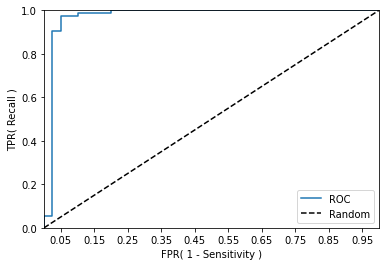

In [0]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])

In [0]:
from sklearn.metrics import precision_recall_curve

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'] )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 64건이므로 샘플로 10건만 추출하되, 임곗값을 6 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 6)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (64,)
반환된 precisions 배열의 Shape: (65,)
반환된 recalls 배열의 Shape: (65,)
thresholds 5 sample: [0.11680892 0.12115615 0.13247421 0.16756983 0.16990103]
precisions 5 sample: [0.90243902 0.90123457 0.9125     0.92405063 0.93589744]
recalls 5 sample: [1.         0.98648649 0.98648649 0.98648649 0.98648649]
샘플 추출을 위한 임계값 배열의 index 10개: [ 0  6 12 18 24 30 36 42 48 54 60]
샘플용 10개의 임곗값:  [0.12 0.35 0.56 0.78 0.89 0.94 0.98 0.99 0.99 0.99 0.99]
샘플 임계값별 정밀도:  [0.902 0.947 0.971 0.984 0.983 0.981 0.978 0.975 0.97  0.963 1.   ]
샘플 임계값별 재현율:  [1.    0.973 0.919 0.851 0.77  0.689 0.608 0.527 0.432 0.351 0.054]


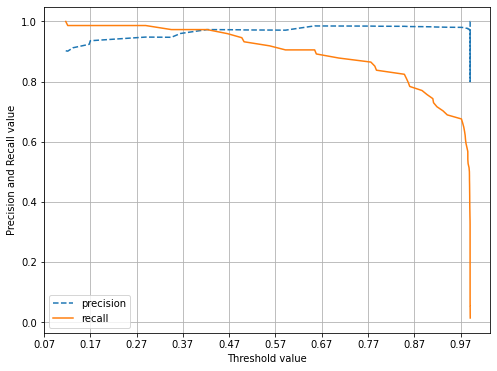

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])